In [1]:
%matplotlib ipympl

import traceback
from onix.data_tools import get_experiment_data
from functools import partial
from onix.analysis.fitter import Fitter
from onix.analysis.helper import group_and_average_data
import numpy as np
from matplotlib import colormaps
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import voigt_profile

In [2]:
def decay(x, a, tau):
    return a*np.exp(-x/tau) 

def get_decay_fit(xs, ys):
    fitter = Fitter(decay)
    fitter.set_absolute_sigma(False)
    fitter.set_p0({"a": -1, "tau": 10000})
    fitter.set_data(xs, ys)
    fitter.fit()
    
    return fitter

In [3]:
def averaged_data_from_number(data_number):
    data, headers = get_experiment_data(data_number)
    transmissions_avg = group_and_average_data(data["transmissions_avg"], headers["params"]["detect"]["cycles"])
    monitors_avg = group_and_average_data(data["monitors_avg"], headers["params"]["detect"]["cycles"])
    return (transmissions_avg, monitors_avg, headers)

In [4]:
def gaussian(f, f_0, a, sigma, b, c):
    numerator = (f - f_0) ** 2
    denominator = 2 * sigma ** 2
    return a * np.exp(-numerator / denominator) + c + b * (f - f_0)

def get_gaussian_fit(detunings, voltages, p0=None):
    fitter = Fitter(gaussian)
    fitter.set_absolute_sigma(False)
    fitter.set_data(detunings, voltages)
    fitter.set_p0({"f_0": 0})
    #fitter.set_bounds("a", -np.inf, 0)
    #fitter.set_bounds("c", 0, np.inf)
    #fitter.set_p0({"a": -1})
    if p0 is not None:
        fitter.set_p0(p0)
    fitter.fit()
    
    return fitter

def gaussian_fits_from_data(transmissions_avg, monitors_avg, headers, default_p0=None):
    antihole_avg = transmissions_avg["antihole"] / monitors_avg["antihole"]
    rf_avg = transmissions_avg["antihole_delay"] / monitors_avg["antihole_delay"]
    print(rf_avg)
    if "chasm" in transmissions_avg:
        chasm_avg = transmissions_avg["chasm"]
        antihole_normalized = antihole_avg / chasm_avg
        rf_normalized = rf_avg / chasm_avg
    else:
        antihole_normalized = antihole_avg
        rf_normalized = rf_avg

    detunings = headers["detunings"].to("MHz").magnitude
    use_field_plate = headers["params"]["field_plate"]["use"]
    positive_field_plate = headers["params"]["field_plate"]["amplitude"] > 0

    p0 = {"sigma": 0.3}
    if default_p0 is None:
        default_p0 = {}
    p0.update(default_p0)
    
    if not use_field_plate:
        fits = {0: {}}
        antihole_fit = get_gaussian_fit(detunings, antihole_normalized, p0=p0)
        fits[0]["ah"] = antihole_fit
        
        rf_fit = get_gaussian_fit(detunings, rf_normalized, p0=p0)
        fits[0]["rf"] = rf_fit
    else:
        fits = {1: {}, -1: {}}
        for label in [1, -1]:
            positive_stark_shift = (label * positive_field_plate) > 0
            if positive_stark_shift:
                mask = detunings > 0
            else:
                mask = detunings < 0
            antihole_fit = get_gaussian_fit(detunings[mask], antihole_normalized[mask], p0=p0)
            fits[label]["ah"] = antihole_fit
            
            rf_fit = get_gaussian_fit(detunings[mask], rf_normalized[mask], p0=p0)
            fits[label]["rf"] = rf_fit
    return fits

def ah_parameters_from_data(transmissions_avg, monitors_avg, headers):
    antihole_avg = transmissions_avg["antihole"] / monitors_avg["antihole"]
    rf_avg = transmissions_avg["antihole_delay"] / monitors_avg["antihole_delay"]
    if "chasm" in transmissions_avg:
        chasm_avg = transmissions_avg["chasm"]
        antihole_normalized = antihole_avg / chasm_avg
        rf_normalized = rf_avg / chasm_avg
    else:
        antihole_normalized = antihole_avg
        rf_normalized = rf_avg

    detunings = headers["detunings"].to("MHz").magnitude
    use_field_plate = headers["params"]["field_plate"]["use"]
    positive_field_plate = headers["params"]["field_plate"]["amplitude"] > 0
    
    if not use_field_plate:
        off_resonant_index = np.argmax(np.abs(detunings) > 0)
        on_resonant_index = 1 - off_resonant_index
        heights = {0: {}}
        backgrounds = {0: {}}
        heights[0]["ah"] = 1 - antihole_avg[on_resonant_index] / antihole_avg[off_resonant_index]
        heights[0]["rf"] = 1 - rf_avg[on_resonant_index] / rf_avg[off_resonant_index]
        backgrounds[0]["ah"] = antihole_avg[off_resonant_index]
        backgrounds[0]["rf"] = rf_avg[off_resonant_index]
    else:
        raise NotImplementedError()
    return (heights, backgrounds)

In [5]:
def ah_height_from_data(transmissions_avg, monitors_avg, headers):
    antihole_heights_1_avg = transmissions_avg["antihole"]
    antihole_heights_2_avg = transmissions_avg["antihole_delay"]
    detunings = headers["detunings"].to("MHz").magnitude
    off_resonant_index = np.argmax(np.abs(detunings) > 0)
    on_resonant_index = 1 - off_resonant_index
    heights = {}
    heights["antihole_heights_1"] = 1 - antihole_heights_1_avg[on_resonant_index] / antihole_heights_1_avg[off_resonant_index]
    heights["antihole_heights_2"] = 1 - antihole_heights_2_avg[on_resonant_index] / antihole_heights_2_avg[off_resonant_index]
    return heights

In [6]:
def rf_spectroscopy_ah_ratio(data_numbers, method="auto"):
    rf_heights = {}
    antihole_heights = {}
    rf_backgrounds = {}
    antihole_backgrounds = {}
    headers = []
    for data_number in data_numbers:
        transmissions_avg, monitors_avg, headers_single = averaged_data_from_number(data_number)
        if method == "auto":
            detunings_len = len(headers_single["detunings"])
            if detunings_len > 4:
                method = "fit"
            else:
                method = "ratio"
        if method == "fit":
            try:
                fits = gaussian_fits_from_data(transmissions_avg, monitors_avg, headers_single)
            except RuntimeError as e:
                print(f"Fitting error for data number #{data_number}:")
                raise e
            for label in fits:
                if label not in rf_heights:
                    rf_heights[label] = []
                    antihole_heights[label] = []
                    rf_backgrounds[label] = []
                    antihole_backgrounds[label] = []
                rf_heights[label].append(fits[label]["rf"].results["a"] / fits[label]["rf"].results["c"])
                antihole_heights[label].append(fits[label]["ah"].results["a"] / fits[label]["ah"].results["c"])
                rf_backgrounds[label].append(fits[label]["rf"].results["c"])
                antihole_backgrounds[label].append(fits[label]["ah"].results["c"])
        elif method == "ratio":
            heights, backgrounds = ah_parameters_from_data(transmissions_avg, monitors_avg, headers_single)
            for label in heights:
                if label not in rf_heights:
                    rf_heights[label] = []
                    antihole_heights[label] = []
                    rf_backgrounds[label] = []
                    antihole_backgrounds[label] = []
                rf_heights[label].append(heights[label]["rf"])
                antihole_heights[label].append(heights[label]["ah"])
                rf_backgrounds[label].append(backgrounds[label]["rf"])
                antihole_backgrounds[label].append(backgrounds[label]["ah"])
        headers.append(headers_single)
    for label in rf_heights:
        rf_heights[label] = np.array(rf_heights[label])
        antihole_heights[label] = np.array(antihole_heights[label])
        rf_backgrounds[label] = np.array(rf_backgrounds[label])
        antihole_backgrounds[label] = np.array(antihole_backgrounds[label])
    return (rf_heights, antihole_heights, rf_backgrounds, antihole_backgrounds, headers)

In [7]:
def data_identification_to_list(data_identification):
    if isinstance(data_identification, tuple):
        return range(data_identification[0], data_identification[1] + 1)
    elif isinstance(data_identification, int):
        return [data_identification]
    else:
        # it should be a list
        return data_identification

In [8]:
def plot_antihole_lifetime(data):
    fig, ax = plt.subplots(figsize = (12, 6), dpi = 120)
    for ll, (label, data_range) in enumerate(data.items()):
        data_list = data_identification_to_list(data_range)
        ah_heights_2, ah_heights_1, ah_bgs_2, ah_bgs_1, headers = rf_spectroscopy_ah_ratio(data_list)
        xs = [header["params"]["detect"]["delta_detect_time"].to("s").magnitude for header in headers]
        ys = (ah_heights_2[0] / ah_bgs_2[0]) / (ah_heights_1[0] / ah_bgs_1[0])
        ys = (ah_heights_2[0] / ah_bgs_2[0]) / (ah_heights_1[0] / ah_bgs_1[0])
    
    
        xs_fit = np.array(xs)
        ys_fit = np.array(ys)
        
        fitter = get_decay_fit(xs_fit, ys_fit)
        xs_fitter = np.linspace(min(xs_fit), max(xs_fit), 1000)

        lifetime = fitter.results["tau"]
        lifetime_err = fitter.errors["tau"]
        units = "seconds"
        if lifetime > 3600:
            lifetime /= 3600
            lifetime_err /= 3600
            units = "hours"
            
            
        lifetime_label = rf"{label} $\tau$ = {lifetime:.1f} $\pm$ {lifetime_err:.1f} {units}"
        
        ax.scatter(xs, ys, label=label + f"")
        ax.plot(xs_fitter, fitter.fitted_value(xs_fitter), label = "decay fit")
        ax.text(min(xs_fit), min(ys_fit)*0.995, lifetime_label)
        print(fitter.all_results_str())
    
    
    ax.set_xscale("log")
    #ax.set_yscale("log")
    ax.set_xlabel("time (s)")
    ax.set_ylabel("ratio of delayed antihole detect to first antihole detect")
    ax.legend()
    ax.grid()
    plt.tight_layout()
    plt.show()

<h2>Cable changes on March 12, 2024</h2>
https://electricatoms.wordpress.com/2024/03/12/antihole-lifetime-measurements/

[1586.45369882 1666.59479417 1682.53829648 1625.2048583  1650.16340706
 1564.68959543 1665.38122057 1686.32627833 1673.28203688 1558.29657927
 1641.17177344 1546.32794858 1644.1396454  1622.70666427 1653.04376071
 1694.20450351 1654.55411571 1748.66895369 1672.86874031 1736.27083926]
Fitting error for data number #110495:


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.

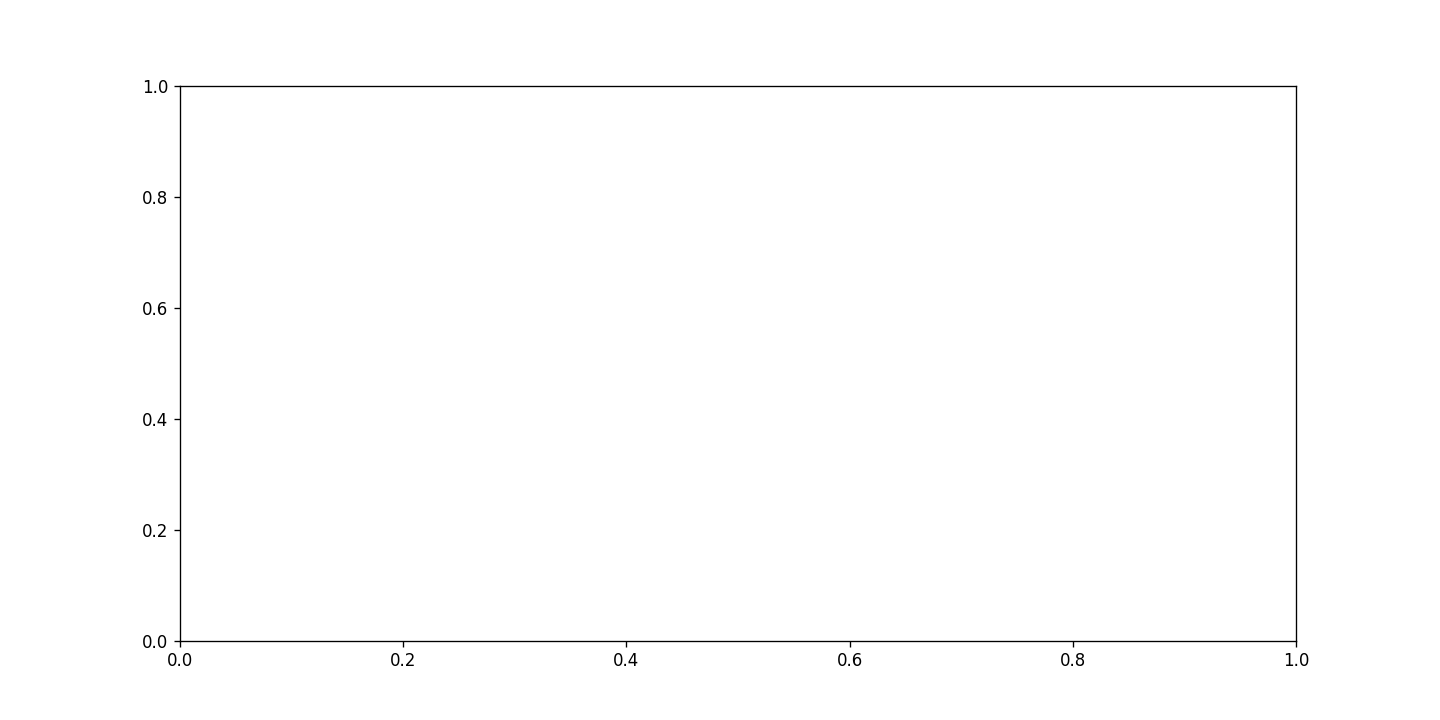

In [10]:
data = {
    "before cable change": (110495, 110544),
    "after cable change": (166435, 166484),
}

plot_antihole_lifetime(data)



<h2>Temperature test May 14, 2024</h2>

[2758.80350781 3018.74899807 3031.42354493 3072.38604789 2993.73666288
 2853.92995267 2941.20404488 2935.56526549 3032.43172805 3065.98797595
 3058.92492837 3071.66019836 3050.63913978 2975.65669336 2850.97489879
 2797.02912361 2972.57364787 2895.97624098 2868.96485261 2738.01905814]
Fitting error for data number #329150:


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.

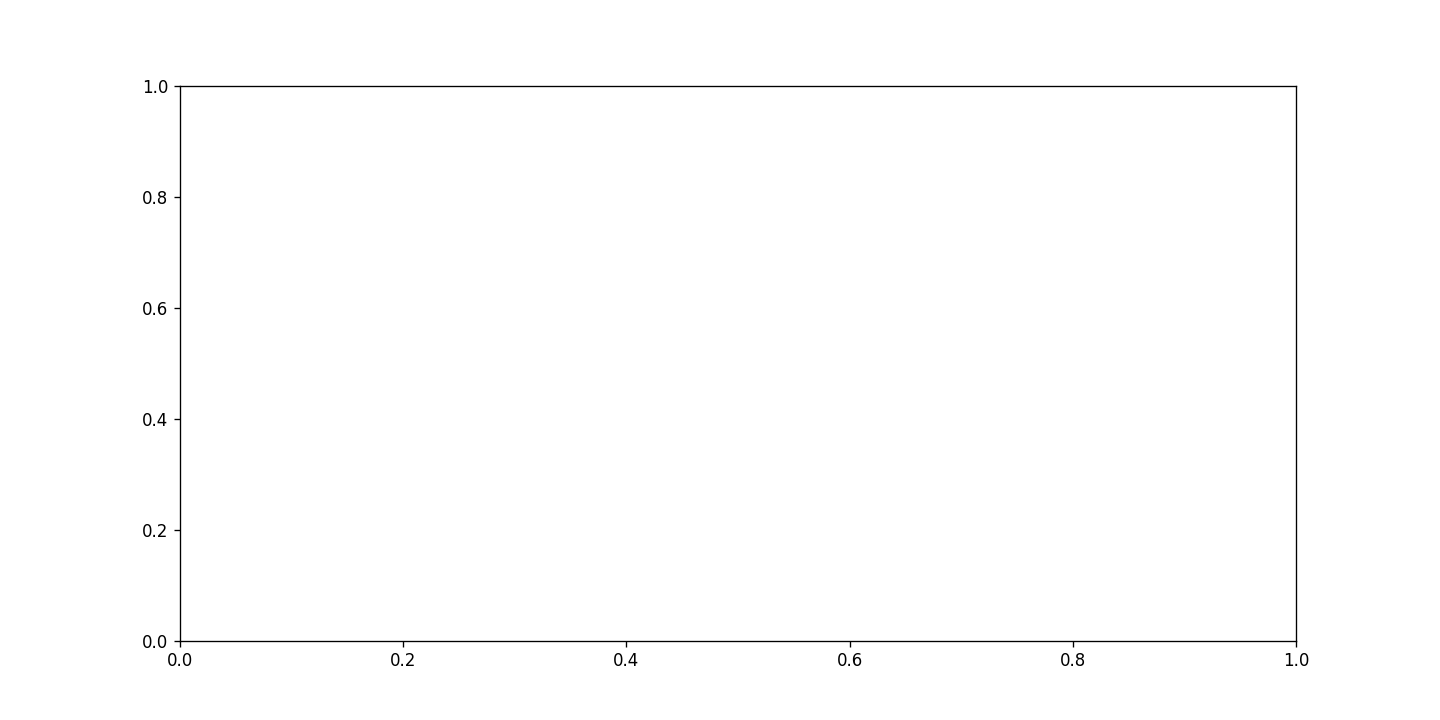

In [11]:
data = {
    "1": (329150, 329196),
}

fig, ax = plt.subplots(figsize = (12, 6), dpi = 120)
for ll, (label, data_range) in enumerate(data.items()):
    data_list = data_identification_to_list(data_range)
    ah_heights_2, ah_heights_1, ah_bgs_2, ah_bgs_1, headers = rf_spectroscopy_ah_ratio(data_list)
    xs = [header["params"]["detect"]["delta_detect_time"].to("s").magnitude for header in headers]
    ys = (ah_heights_2[0] / ah_bgs_2[0]) / (ah_heights_1[0] / ah_bgs_1[0])

    xs_fit = np.array(xs)
    ys_fit = np.array(ys)
    
    #fitter = get_decay_fit(xs_fit, ys_fit)
    #xs_fitter = np.linspace(min(xs_fit), max(xs_fit), 1000)
    
    ax.scatter(xs, ys, label=label + f"")
    #ax.plot(xs_fitter, fitter.fitted_value(xs_fitter), label = "decay fit")
    #ax.text(min(xs_fit), min(ys_fit)*0.995, rf"{label} $\tau$ = {fitter.results["tau"] / 3600 :.1f} $\pm$ {fitter.errors["tau"] / 3600 :.1f} hrs")
    #print(fitter.all_results_str())


ax.set_xscale("log")
ax.set_xlabel("time (s)")
ax.set_ylabel("ratio of delayed antihole detect to first antihole detect")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

[-1914.23370938 -1944.7539214  -1921.7255795  -1953.01512998
 -1910.67210707 -1916.29168374 -1921.22265143 -1955.86954357
 -1902.45986258 -1795.3319107  -1754.82443372 -1793.31050303
 -1870.75010265 -1898.89090167 -1945.6195599  -1939.27967611
 -1945.29597891 -1958.04712813 -1967.55942029 -1945.04277457]
Fitting error for data number #166435:


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.

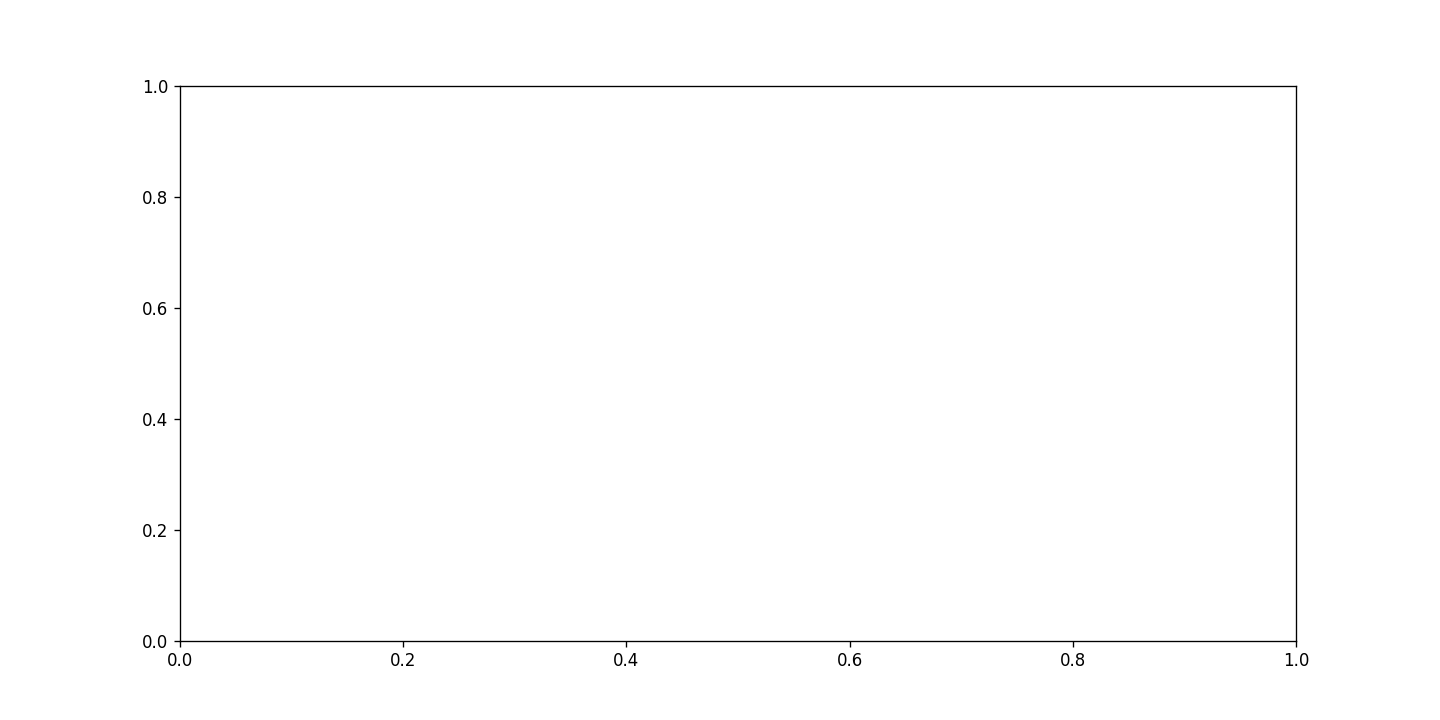

In [12]:
data = {
    "before cool down on may-10": (166435, 166484),
    "after cool down on may-10; data taken on may-14": (329498, 329522),
}

plot_antihole_lifetime(data)

[0.70156004 0.70176078 0.70158433 0.7010955  0.69995394 0.69932936
 0.6989288  0.69913546 0.70052566 0.70011964 0.70024407 0.7006765 ]
[0.77076906 0.77055849 0.77000448 0.76941114 0.76837526 0.7677322
 0.76719468 0.76831578 0.76933716 0.7695225  0.76919487 0.76940948]


/home/icarus/.venv/vlab/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


OverflowError: cannot convert float infinity to integer

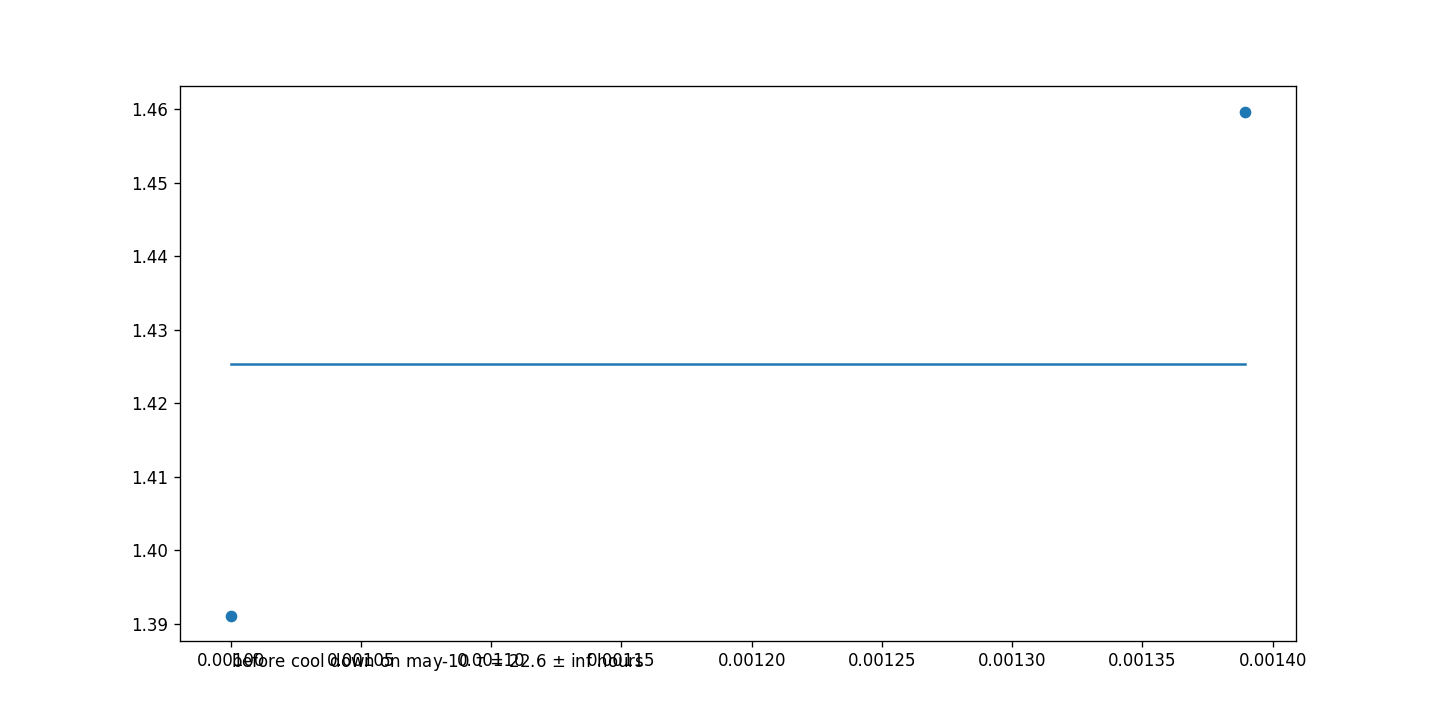

In [13]:
data = {
    "before cool down on may-10": (519471, 519472),
}

plot_antihole_lifetime(data)

In [10]:
def plot_decay(data):
    def get_height(data_number):
        data, headers = get_experiment_data(data_number)
        
        detunings_MHz = headers["detunings"].to("MHz").magnitude
        transmissions_avg = group_and_average_data(data["transmissions_avg"], headers["params"]["detect"]["cycles"])
        monitors_avg = group_and_average_data(data["monitors_avg"], headers["params"]["detect"]["cycles"])
        
        antihole1_avg = transmissions_avg["antihole"] / monitors_avg["antihole"]
        antihole2_avg = transmissions_avg["antihole_delay"] / monitors_avg["antihole"]
        
        antihole1_fit = get_gaussian_fit(detunings_MHz, antihole1_avg)
        antihole2_fit = get_gaussian_fit(detunings_MHz, antihole2_avg)
    
        delta_detect_time = headers["params"]["detect"]["delta_detect_time"].to("s").magnitude
        
        return (antihole1_fit.results["a"], antihole2_fit.results["a"], delta_detect_time)
    fig, ax = plt.subplots(figsize = (12, 6), dpi = 120)
    for ll, (label, data_range) in enumerate(data.items()):
        xs = []
        ys = []
        for data_number in range(data_range[0], data_range[1]+1):
            ah1, ah2, dt = get_height(data_number)
            xs.append(dt)
            ys.append(ah2/ah1)
            
        xs_fit = np.array(xs)
        ys_fit = np.array(ys)
        
        fitter = get_decay_fit(xs_fit, ys_fit)
        xs_fitter = np.linspace(min(xs_fit), max(xs_fit), 1000)

        lifetime = fitter.results["tau"]
        lifetime_err = fitter.errors["tau"]
        print(lifetime)
        ax.scatter(xs, ys, label=label + f": lifetime {lifetime:.0f} s")
        ax.plot(xs_fitter, fitter.fitted_value(xs_fitter))
        
    ax.set_xscale("log")
    #ax.set_yscale("log")
    ax.set_xlabel("time (s)")
    ax.set_ylabel("ratio of delayed antihole detect to first antihole detect")
    ax.legend()
    ax.grid()
    plt.tight_layout()
    plt.show()

4589.326353210336


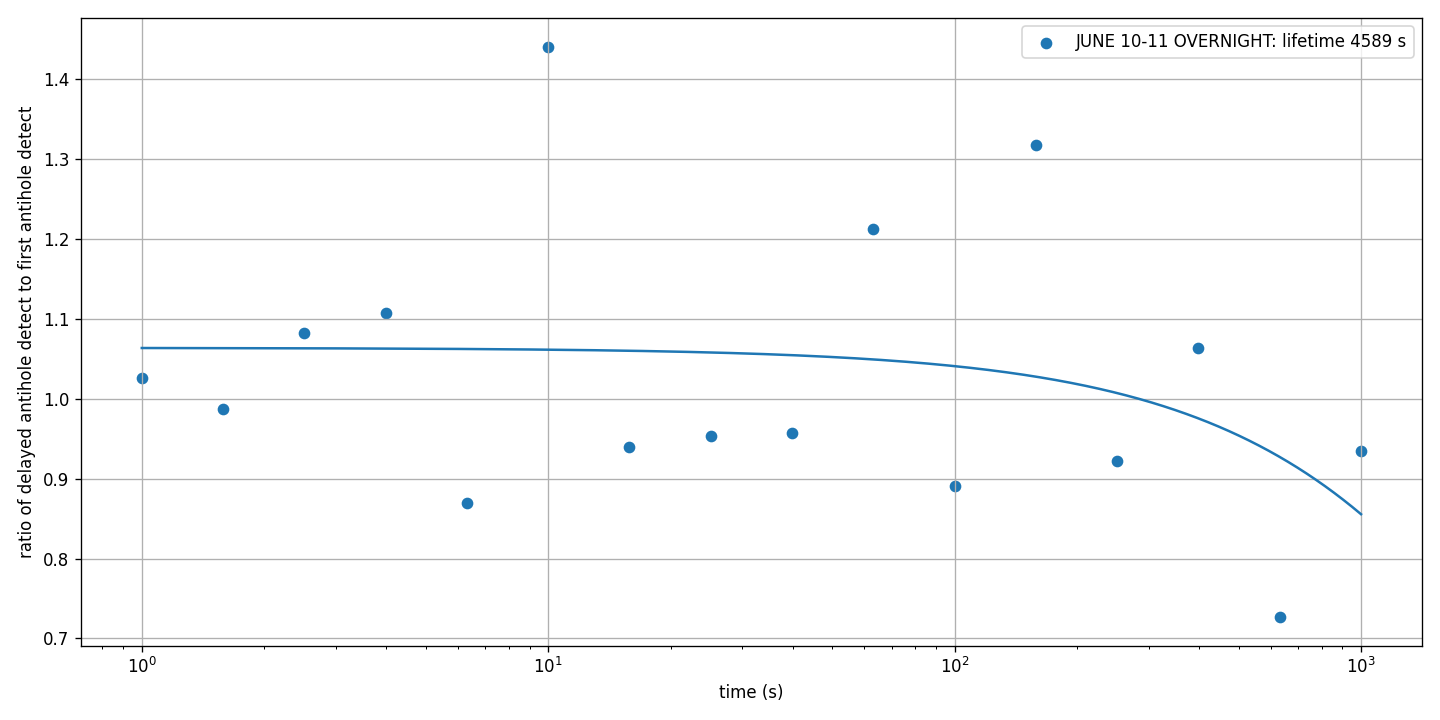

In [15]:
data = {
    # "JUNE 5": (519471, 519511),
    # "JUNE 5-6 OVERNIGHT": (520366, 520385),
    #"JUNE 7-8 OVERNIGHT": (522099, 522119),
    "JUNE 10-11 OVERNIGHT": (525286, 525301),
}

plot_decay(data)

# 

26606.412726372928
19118.403743695562
23194.282492901773
15141.72076865412
12086.670831330879
12691.087783337643
8853.33326786088
7361.617666454417
5673.069345015791
4176.475079753728


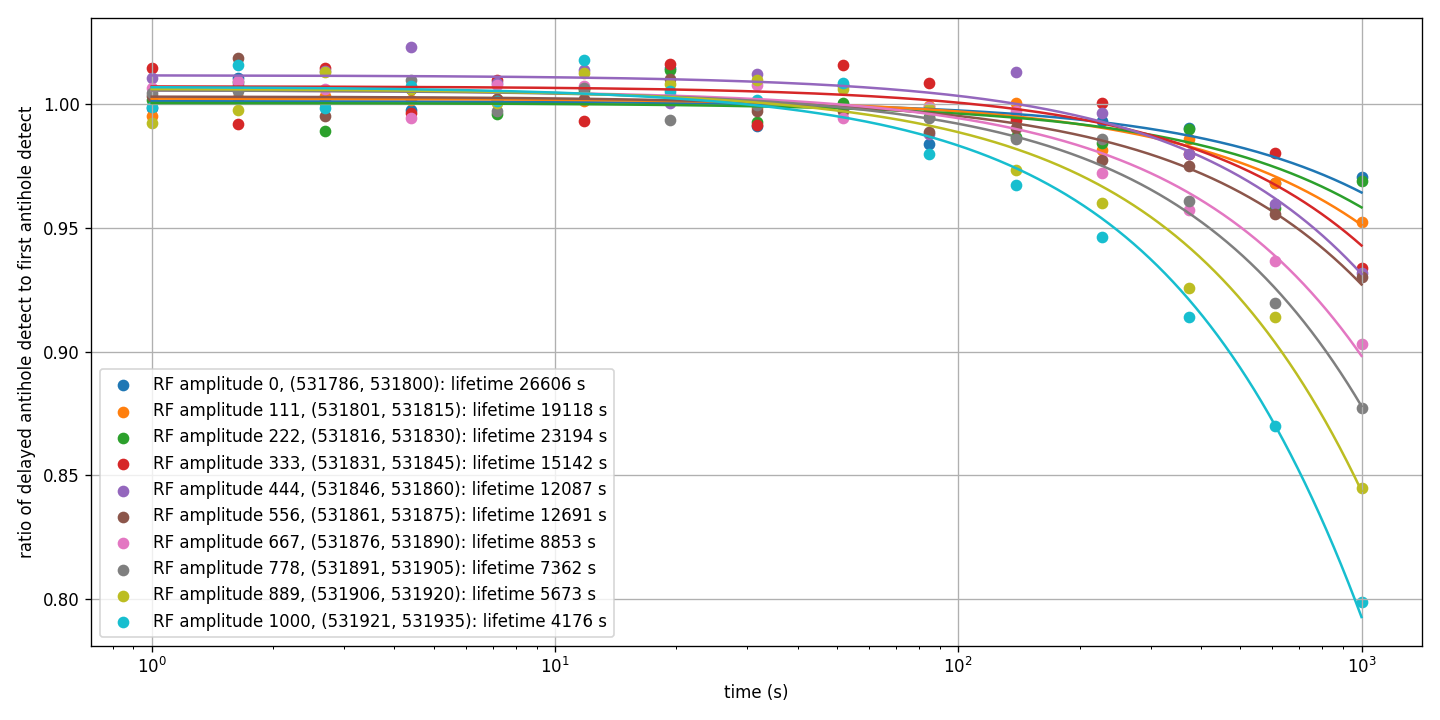

In [29]:
data = {
    "": (531786, 531935),
}
start = 531786
data = {}
for kk in range(10):
    data1, headers = get_experiment_data(start)
    data[f'RF amplitude {headers["params"]["rf"]["amplitude"]:.0f}, {(start, start + 14)}'] = (start, start + 14)
    start += 15
plot_decay(data)

4371.947198398597


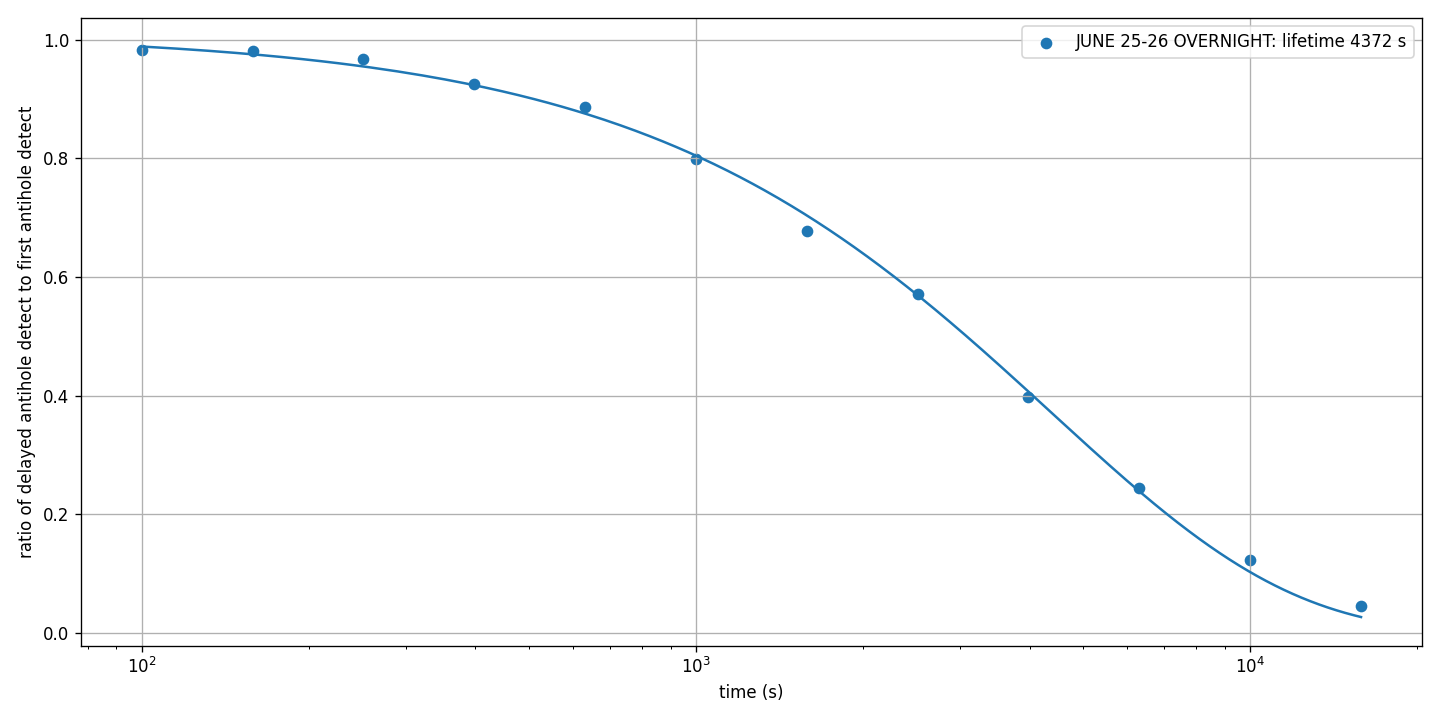

In [18]:
data = {
    "JUNE 25-26 OVERNIGHT": (592446, 592457),
}
plot_decay(data)

-19163.948565936276
-504283325.0482766
1160951518.373683


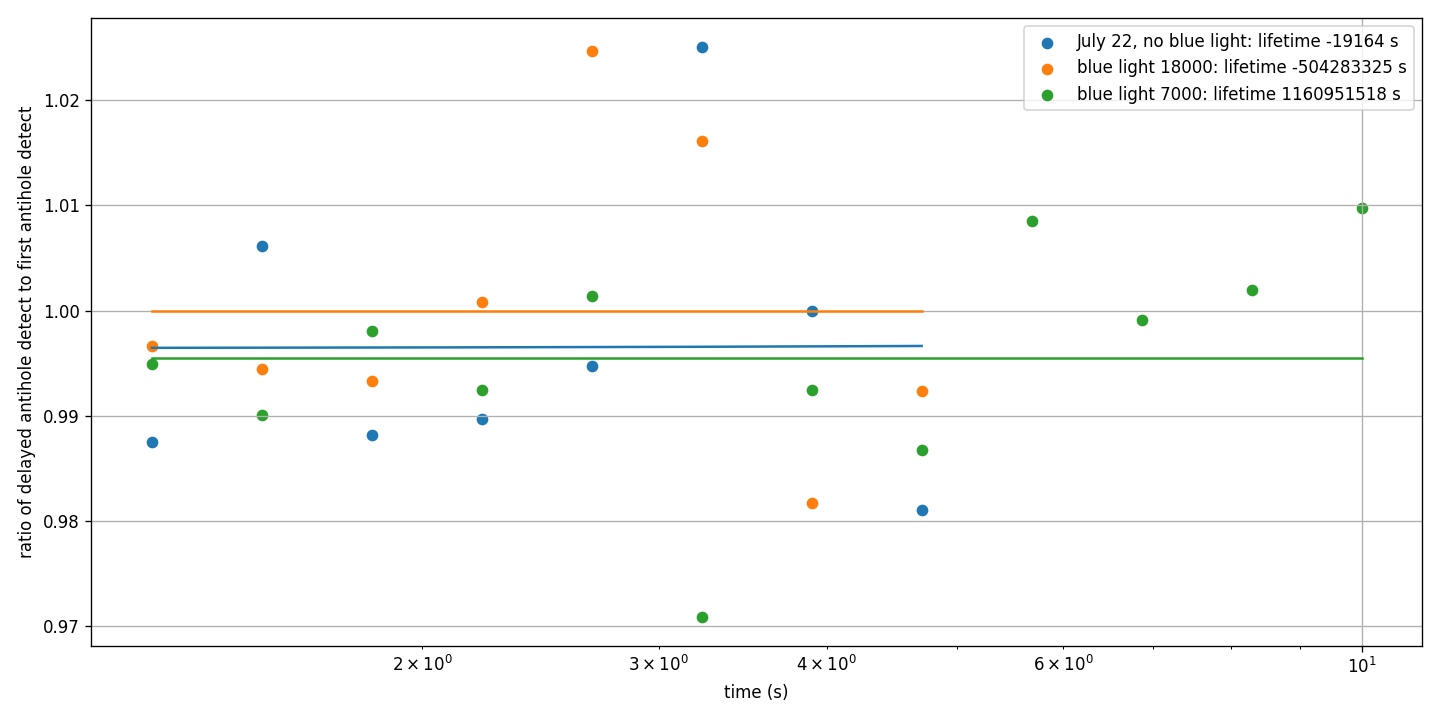

In [19]:
data = {
    "July 22, no blue light": (1570839, 1570846),
    "blue light 18000": (1570851, 1570858),
    "blue light 7000": (1570863, 1570874),
}
plot_decay(data)